In [169]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [171]:
def compute_fpr_fnr(eval_res):
        
    if eval_res.val_gt is None:
        res = [{'fpr_nt': 0,'fpr_un':  0,'fnr':  0}]
    else:
        y_true = eval_res.test_unkn_gt
        y_probs = eval_res.test_unkn_probs
        y_pred = np.argmax(y_probs, axis=1)

        y_true_neg = eval_res.test_neg_gt
        y_probs_neg = eval_res.test_neg_probs
        y_pred_neg = np.argmax(y_probs_neg, axis=1)
        
        res = []
        classes = [uq for uq in np.unique(y_true) if uq >=0]
        for c in classes:
            # one-vs-rest
            y_true_c = y_true == c
            y_pred_c = y_probs[range(len(y_pred)), c] >= 0.5

            tmp_res = {}
            # FPR - Non-Target
            mask_1 = np.logical_or(y_true_c, y_true != -1)
            y_true_c_1 = y_true_c[mask_1]
            y_pred_c_1 = y_pred_c[mask_1]
            tn, fp, fn, tp = metrics.confusion_matrix(y_true_c_1, y_pred_c_1).ravel()
            tmp_res['fpr_nt'] = fp/(fp + tn)
            tmp_res['fnr'] = fn/(fn + tp)

            # FPR - Unknown
            mask_2 = np.logical_or(y_true_c, y_true == -1)
            y_true_c_2 = y_true_c[mask_2]
            y_pred_c_2 = y_pred_c[mask_2]
            tn, fp, fn, tp = metrics.confusion_matrix(y_true_c_2, y_pred_c_2).ravel()
            tmp_res['fpr_u'] = fp/(fp + tn)


            # FPR - Negative
            y_true_c = y_true_neg == c
            y_pred_c = y_probs_neg[range(len(y_pred_neg)), c] >= 0.5

            mask_2 = np.logical_or(y_true_c, y_true_neg == -1)
            y_true_c_2 = y_true_c[mask_2]
            y_pred_c_2 = y_pred_c[mask_2]
            tn, fp, fn, tp = metrics.confusion_matrix(y_true_c_2, y_pred_c_2).ravel()
            tmp_res['fpr_n'] = fp/(fp + tn)

            res.append(tmp_res)

    return res


def get_openset_perf(test_gt:np.array, test_probs:np.array, unkn_gt_label=-1, is_verbose=False):

    # vary thresholds
    ccr, fpr = [], []
    kn_probs = test_probs[test_gt != unkn_gt_label]
    unkn_probs = test_probs[test_gt == unkn_gt_label]
    gt = test_gt[test_gt != unkn_gt_label]

    # Get CCR and FPR
    thresholds = sorted(np.append(kn_probs[range(len(gt)),gt], np.max(unkn_probs, axis=1)))
    for tau in tqdm(thresholds, miniters=int(len(gt)/5), maxinterval=600, disable=not is_verbose):
        # correct classification rate
        ccr.append(np.sum(np.logical_and(
            np.argmax(kn_probs, axis=1) == gt,
            kn_probs[range(len(gt)),gt] >= tau
        )) / len(kn_probs))
        # false positive rate for validation and test set
        fpr.append(np.sum(np.max(unkn_probs, axis=1) >= tau) / len(unkn_probs))
    
    # Get URR and OSA
    alpha = sum(test_gt != unkn_gt_label) / len(test_gt)
    urr = [1-v for v in fpr]
    osa = [alpha * c + (1-alpha) * u for c,u in zip(ccr,urr)]

    return (ccr, fpr, urr, osa, thresholds)


# Large Scale Setting

## Init

In [172]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  

#### Evaluation data from OvR
ovr_data_info_1 = [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]
ovr_data_info_2_T = [
    {
        'C':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
    {
        'C':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
             {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},]
    },
]
ovr_data_info_3_T =[
    {
        'base': [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
    {
        'base': [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR-C (b w/ neg)'}],
        'C' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg)'},],
        'F' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg)'},],
        'M' : [{'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.4 w/ neg)'},
               {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg)'},]
    },
]

## Test

In [173]:
PROTOCOL = 2

In [174]:
no_neg_data_info = []
no_neg_data_info.append(ovr_data_info_1[PROTOCOL-1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['C'][1])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['F'][0])
no_neg_data_info.append(ovr_data_info_2_T[PROTOCOL-1]['M'][0])

for idx in range(len(no_neg_data_info)):
    print(no_neg_data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_02', 'OvR']


In [175]:
neg_data_info = []
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['base'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['C'][0])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['F'][2])
neg_data_info.append(ovr_data_info_3_T[PROTOCOL-1]['M'][0])

for idx in range(len(neg_data_info)):
    print(neg_data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_02', 'OvR']


In [176]:
for idx, d_i in enumerate(neg_data_info[:1]):

    info = d_i['info']
    
    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path)

    eval_res.test_neg_gt
    eval_res.test_neg_logits
    eval_res.test_neg_probs

    eval_res.test_unkn_gt
    eval_res.test_unkn_logits
    eval_res.test_unkn_probs

    # (ccr, fpr, urr, osa, thresholds) = get_openset_perf(eval_res.test_neg_gt,
    #                                                     eval_res.test_neg_probs,
    #                                                     is_verbose=True)
    
    # fpr_fnr_res = compute_fpr_fnr(eval_res)
    # oosa = evals.compute_oosa(eval_res.val_thrs, eval_res.val_osa, 
    #                     eval_res.test_neg_thrs, eval_res.test_neg_osa, 
    #                     eval_res.test_unkn_thrs, eval_res.test_unkn_osa)



In [179]:
c = 0

target_mask = eval_res.test_neg_gt == c
neg_mask = eval_res.test_neg_gt == -1
non_target_mask = np.logical_and(~target_mask, ~neg_mask)

logits = eval_res.test_neg_logits.copy()
target_logtis = logits[target_mask, c]
neg_logtis = logits[neg_mask, c]
non_target_logtis = logits[non_target_mask, c]

In [182]:
np.mean(target_logtis), np.mean(neg_logtis), np.mean(non_target_logtis)

(-0.14503135412931442, -21.701215419230923, -18.91772664421591)

In [183]:
target_logits_hist, _ = np.histogram(target_logtis)

(array([  2.,   1.,   0.,   1.,   3.,  16., 147., 629., 565.,  86.]),
 array([-101.50521088,  -90.99782872,  -80.49044657,  -69.98306441,
         -59.47568226,  -48.9683001 ,  -38.46091795,  -27.9535358 ,
         -17.44615364,   -6.93877149,    3.56861067]),
 <BarContainer object of 10 artists>)

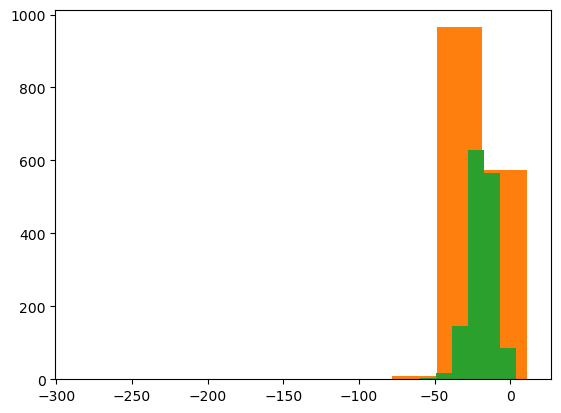

In [186]:
plt.hist(target_logtis)
plt.hist(neg_logtis)
plt.hist(non_target_logtis)